In [2]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


G:\Documents\000_USF\2019_Spring\Numerical_Methods


# Week 5

Testing some things concerning boundary conditions

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from tabulate import tabulate

In [4]:
A = np.arange(0,16).reshape((4,4)) # making square matrix
A[1:-1,1:-1] = np.arange(100,500,100).reshape((2,2))     # in numpy slices can be assigned to 
A

array([[  0,   1,   2,   3],
       [  4, 100, 200,   7],
       [  8, 300, 400,  11],
       [ 12,  13,  14,  15]])

In [5]:
N = 6
L = 1 
H = 1 
x,y = np.meshgrid(np.linspace(0,H,N),np.linspace(L,0,N)) # making grid of x,y points
y = y[::-1,:] # flipping y vertically as meshgrid doesnt want to make y increasing from top to bottom
print(x)
print(y)

[[0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]
 [0.  0.2 0.4 0.6 0.8 1. ]]
[[0.  0.  0.  0.  0.  0. ]
 [0.2 0.2 0.2 0.2 0.2 0.2]
 [0.4 0.4 0.4 0.4 0.4 0.4]
 [0.6 0.6 0.6 0.6 0.6 0.6]
 [0.8 0.8 0.8 0.8 0.8 0.8]
 [1.  1.  1.  1.  1.  1. ]]


In [6]:
phi = np.zeros((N,N)) # could make boundary conditions later
phi[0,:]  = np.ones(N)
phi[-1,:]  = np.ones(N)
phi[:,0]  = np.ones(N)
phi[:,-1]  = np.ones(N)

phi

array([[1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1.]])

In [7]:
N_i = N-2
dx_sq = (L/(N+1))**2
dy_sq = (H/(N+1))**2
A = sp.diags([-1/dx_sq,-1/dy_sq, 2/dx_sq+2/dy_sq,-1/dy_sq,-1/dx_sq], [-N,-1, 0, 1,N], shape=((N-2)**2, (N-2)**2))

In [8]:

b = np.zeros((N-2)**2)
b[0             :N_i                    ] += phi[0      ,1:N-1    ]/dx_sq # West
b[(N_i)*(N_i-1) :                       ] += phi[-1     ,1:N-1   ]/dx_sq # East
b[0             :N_i**2             :N_i] += phi[1:N-1  ,0      ]/dy_sq # South
b[N_i-1         :(N_i-1) + N_i**2   :N_i] += phi[1:N-1  ,-1     ]/dy_sq # North
b

array([98., 49., 49., 98., 49.,  0.,  0., 49., 49.,  0.,  0., 49., 98.,
       49., 49., 98.])

In [9]:

def poisson_2D(s_fun,L,H,num_pts,BCs = None):
    ''' 
    `s_fun` source function, should be of form s(x,y)
    `num_pts` - number of divisions used to discretize line
    `BCs` - dict of north, east, south, and west values
        L or H which define boundary conditions at respective borders
    '''
    if BCs is None:
        BCs = {'n':0,'e':0,'s':0,'w':0}
    north,east,south,west = BCs['n'],BCs['e'],BCs['s'],BCs['w']
    if num_pts <3:
        print("Nothing to solve for")
        return
    # Initial Constants
    N = num_pts # less typing
    dx_sq = (L/N)**2
    dy_sq = (H/N)**2

    # Making intitial arrays of size NxN 
    # Each of these arrays will be rotated clockwise 90° in order to support efficient unraveling
    # [[2,4],       -->     [[1,2]
    #  [1,3]]      |         [3,4]]
    #               --
    # and thus slice assignment can be used to re-populate arrays
    x,y = np.meshgrid(np.linspace(0,L,N),np.linspace(0,H,N)) # making grid of x,y points
    y = np.flipud(y) # flip upside down so zero starts at bottom of matrix
    x = np.rot90(x,3) # rotate clockwise 90°
    y = np.rot90(y,3) # rotate clockwise 90°

    # y = np.flipud(y) # flipping y vertically as meshgrid doesnt want to make y increasing from top to bottom
    phi = np.zeros((N,N)) 
    # Where boundary conditions would go
    #north
    phi[:,-1]  = np.full(N,north)
    #east
    phi[-1,:]  = np.full(N,east)
    #south
    phi[:,0]  = np.full(N,south)
    #east
    phi[0,:]  = np.full(N,west)

    s = s_fun(x,y) # should give scalar source function with dimension NxN, already rotated

    # Function that returns middle part flattened
    flat_insides = lambda a: a[1:-1,1:-1].reshape(-1) 

    # Making matrix equation
    # A does not include outer points of phi
    # Note that sign has been swapped, so source is added, and numerical laplacian is negative, 
    # boundary conditions would have positive sign
    N_i = N-2 # dimension of matrix without any outermost entries
    A = sp.diags([-1/dx_sq,-1/dy_sq, 2/dx_sq+2/dy_sq,-1/dy_sq,-1/dx_sq], [-N_i,-1, 0, 1,N_i], shape=(N_i**2, N_i**2),format= 'csr')
    # Now, we must remove the -1 entries which correspond to the beginning and ends of columns, which are not supposed to be connected
    for i in range(N_i-1,N_i**2-1,N_i): 
        # This for loop iterates over the N_i-1 bottom right corners of the N_i x N_i sub-matrices, corresponding to the phi's which are at the 
        # top and bottom of each column (or row for the rotated matrices), which should not be connected to each other as they are not physically adjacent
        A[i,i+1] = 0.0
        A[i+1,i] = 0.0
    A.eliminate_zeros() # Look at my close-to-the-metal optimizations wow
    b = np.zeros(N_i**2)
    b += flat_insides(s) # adding source vector 
    # Adding boundary conditions
    # remember, phi is rotated 90° 
    b[0             :N_i                    ] += phi[0      ,1:N-1  ]/dx_sq # West
    b[(N_i)*(N_i-1) :                       ] += phi[-1     ,1:N-1  ]/dx_sq # East
    b[0             :N_i**2             :N_i] += phi[1:N-1  ,0      ]/dy_sq # South
    b[N_i-1         :(N_i-1) + N_i**2   :N_i] += phi[1:N-1  ,-1     ]/dy_sq # North

    phi[1:-1,1:-1] =  spla.spsolve(A,b.reshape((N_i**2,1))).reshape((N_i,N_i))
    # phi[1:-1,1:-1] =  np.linalg.solve(A.todense(),b.reshape((N_i**2,1))).reshape((N_i,N_i))
    return np.rot90(phi),np.rot90(s),np.rot90(x),np.rot90(y),b # equivalent of MATLAB backslash


In [31]:
# Defining function to plot phi and s with

def plot_phi_s(phi,s,x,y,b):
    #we don't actually use b but this allows us to unpack outputs of poisson 
    plt.contourf(x,y,phi)
    plt.title("$\phi$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.show()

    plt.contourf(x,y,s)
    plt.title("$source$")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.show()

# 1 Zero source $s(x,y)= 0 $

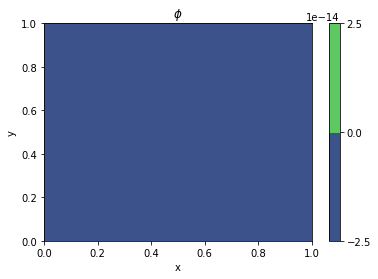

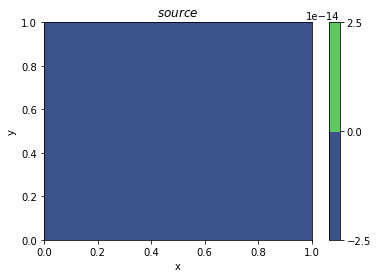

In [22]:
L,H, = 1,1
source_func = lambda x,y:  0*x*y # zero source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100))

# Same problem with N_x = N_y = 5 for taking a look at matrices
 Check out the matrices below, which seem to be properly constructed to me

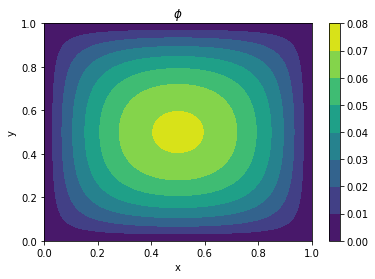

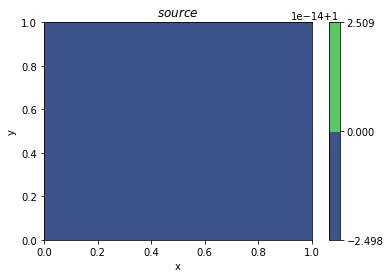

In [15]:
source_func = lambda x,y: 0*x*y+1 # one source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100))


# 3 Linear Source in x varying from 0 to 1 $S(x,y) = \frac{x}{L} $

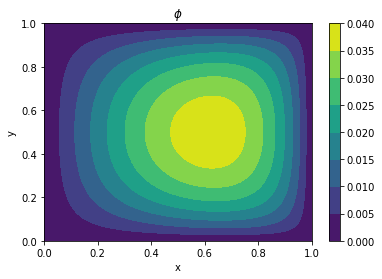

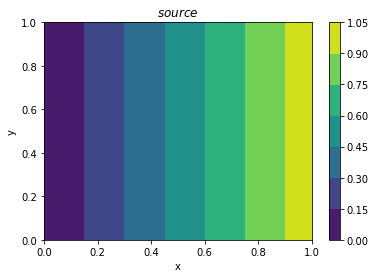

In [19]:
source_func = lambda x,y: x/L + y*0 # zero source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100))


# 4 Linear Source in x and y $S(x,y) = \frac{x}{L}+\frac{2y}{H}  $

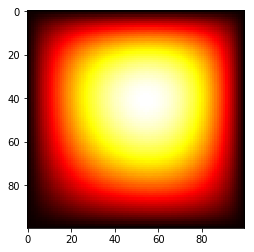

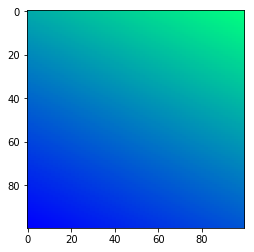

In [11]:
source_func = lambda x,y: x/L+2*y/H # zero source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100))


# 5 Non-Linear Source in x and y $S(x,y) = (\frac{x}{L})^2+\sin(\frac{10y}{H})  $

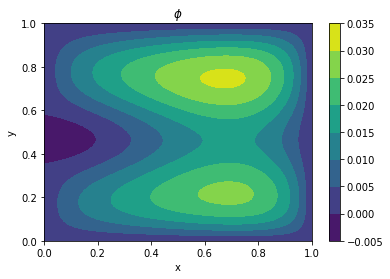

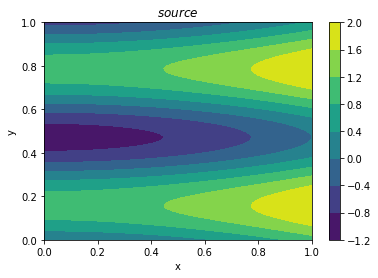

In [23]:
source_func = lambda x,y: np.sin(y*10/H) + (x/L)**2# zero source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100))


# Also I implemented boundary conditions. S(x,y) = 0
# $\varphi(x,H) = 1, \varphi(x,0) = 1 $

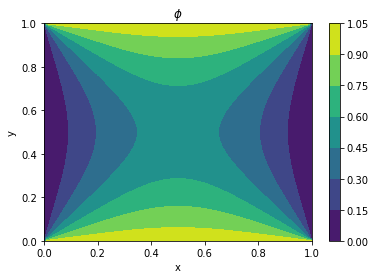

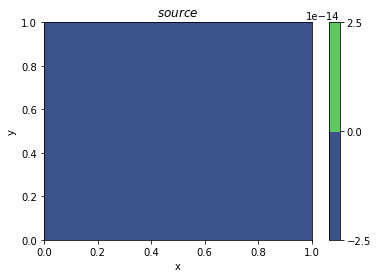

In [26]:
source_func = lambda x,y: 0*x*y # zero source function (multiplication for broadcasting)
plot_phi_s( *poisson_2D(source_func,L=L,H=H,num_pts= 100,BCs = {'n':1,'e':0,'s':1,'w':0}))


#  S(x,y) = 10
# $\varphi(x,H) = 1, \varphi(x,0) = 1 $

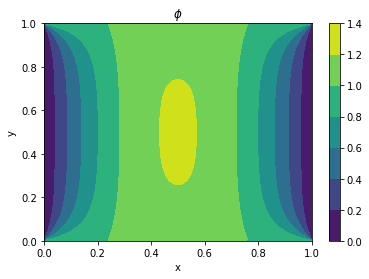

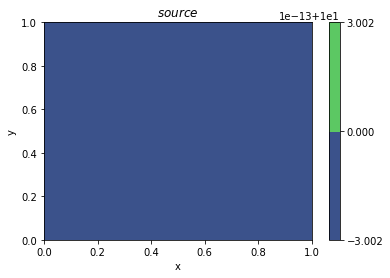

In [29]:
source_func = lambda x,y: 0*x*y+10
plot_phi_s(*poisson_2D(source_func,L=H,H=H,num_pts= 100,BCs = {'n':1,'e':0,'s':1,'w':0}))


# Mesh Refinement

In [15]:
def poisson_with_mesh_refinement(s_fun,L,H,initial_num_pts,BCs=None,tolerance=0.001,max_iters = 10):
    '''
    `initial_num_pts` - number of points to start with
    `tolerance`       - average change in phi which determines convergence criteria
    `max_iters`       - maximum number of iterations to attempt to solve for
    '''
    iteration = 0 
    num_pts = initial_num_pts
    print("Evaluating with num_pts= {}".format(num_pts))
    phi,s,x,y,b = poisson_2D(source_func,L=H,H=H,num_pts= num_pts,BCs = BCs)
    while iteration < max_iters-1:
        new_num_pts = 2*num_pts - 1 # increase the resolution of mesh, subtract 1 so all the points line up when we compare
        print("Evaluating with num_pts= {}".format(num_pts))
        new_phi,s,x,y,b = poisson_2D(source_func,L=H,H=H,num_pts= new_num_pts,BCs = BCs)
        if np.sum(np.abs(new_phi[::2,::2]-phi))/num_pts**2 < tolerance: # We have converged since phi has not changed that much on average
            print("Phi converged")
            break
        phi = new_phi
        num_pts = new_num_pts
        iteration += 1
    else:
        print("Maximum Iterations Reached")
    return new_phi,s,x,y,b 
    

In [30]:

source_func = lambda x,y: 0*x*y+1 # zero source function (multiplication for broadcasting)
phi,s,x,y,b = poisson_with_mesh_refinement(source_func,L=L,H=H,initial_num_pts= 5,tolerance =0.001) # do not put less than 0.001

plot_phi_s(phi,s,x,y,b 

NameError: name 'poisson_with_mesh_refinement' is not defined